## 1.- Import standard libraries

In [1]:
# Import custom libraries from local folder.
from importlib import reload
import os
import sys
sys.path.append("..")

# Import nn module from torch to replicate kessler tool
import torch
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Import utils library containing miscellaneous functions/classes
from scalib import utils

# Import library to import Kelvins challlenge data
from scalib.eda import kelvins_challenge_events

# Import SCALIB modules for NN development
import scalib.xnn as xnn            # NN models

# Set overall seed for reproducibility
utils.seed(1)

# Import matplotlib library and setup environment for plots
%matplotlib inline
%config InlineBackend.figure_format='retina'
from matplotlib import rc

# Set rendering parameters to use TeX font if not working on Juno app.
if not '/private/var/' in utils.cwd:
    rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 11})
    rc('text', usetex=True)

print(utils.cwd)

/Users/jjrr/Documents/SCA-Project/scalib


## 2.- Data preparation

In [2]:
#As an example, we first show the case in which the data comes from the Kelvins competition.
#For this, we built a specific converter that takes care of the conversion from Kelvins format
#to standard CDM format (the data can be downloaded at https://kelvins.esa.int/collision-avoidance-challenge/data/):
filepath = os.path.join(utils.cwd,'data','esa-challenge','train_data.csv')

# Get ConjunctionEventsDataset object 
events = kelvins_challenge_events(filepath,
            drop_features = ['c_rcs_estimate', 't_rcs_estimate'], 
            num_events = 2000)

# Get features to train the model.
nn_features = events.common_features(only_numeric=True)

# Define input and output size of the RNN model.
input_size = len(nn_features)
output_size = len(nn_features)

# Split data into a test set (5% of the total number of events)
len_test_set=int(0.05*len(events))

# Get Events to test model: used to compute the error the model would have in 
# run-mode.
events_test=events[-len_test_set:]
print('\nTest data:', events_test)

# Get events used for training and validation:
# - Training set: Used to train the model and backpropagate the loss.
# - Validation set: Used to compute the loss so that hyperparameters can be 
#   adjusted.
events_train_and_val=events[:-len_test_set]
print('Training and validation data:', events_train_and_val)

Kelvins Challenge dataset imported from external file (162634 entries):
/Users/jjrr/Documents/SCA-Project/scalib/data/esa-challenge/train_data.csv

KELVINS DATASET IMPORT:
| Progress                     |    Time     | Iters/sec | Comments
| 100% |██████████| (2000/2000)| 00h:00m:10s |  185.79   | Dataset imported (2000 events).         

CONJUNCTION EVENTS DATASET -> PANDAS DATAFRAME:
| Progress                     |    Time     | Iters/sec | Comments
| 100% |██████████| (2000/2000)| 00h:00m:31s |   63.70   | Pandas DataFrame saved.                                 

Test data: ConjunctionEventsDataset(Events:100 | Number of CDMs per event: 1 (min), 22 (max), 12.80 (mean))
Training and validation data: ConjunctionEventsDataset(Events:1900 | Number of CDMs per event: 1 (min), 22 (max), 13.45 (mean))


## 3.- Recurrent Neural Network models assessment for Conjunction Event forecasting

### 3.1.- Networks considered in the research

In [36]:
# Import all networks variations
import scalib.nws as nws
reload(nws)

# Iterate over all the networks to get their parameters
data_networks = {}
for name, network in nws.networks.items():

    # Get number of parameters in the model.
    num_params = sum(p.numel() for p in network.parameters())
    for layer_name, layer in network.items():
        if any(arch in layer_name for arch in ['lstm', 'gru', 'mgu']):
            hs = layer.hidden_size
            nl = layer.num_layers
            break
    data_networks[name]=[num_params, hs, nl]

# Convert dictionary to pandas DataFrame
df_networks = pd.DataFrame.from_dict(data=data_networks, 
                                     columns =['parameters', 
                                               'hidden_size', 
                                               'num_layers'], 
                                     orient='index')

# Display table with networks subject to study
df_networks

/Users/jjrr/Documents/SCA-Project/scalib/notebooks/../scalib/layers.py:192: UserWarning: 
Dropout parameter in LSTM class adds dropout layers after all but last recurrent layer. 
It expects num_layers greater > 1, but got num_layers = 1.
  warnings.warn(
/Users/jjrr/Documents/SCA-Project/scalib/notebooks/../scalib/layers.py:405: UserWarning: 
Dropout parameter in LSTM class adds dropout layers after all but last recurrent layer. 
It expects num_layers greater > 1, but got num_layers = 1.
  warnings.warn(


,parameters,hidden_size,num_layers
lstm_vanilla,927762,264,2
lstm_nig,927246,306,2
lstm_nog,927246,306,2
lstm_nfg,927246,306,2
lstm_nigaf,927762,264,2
lstm_nogaf,927762,264,2
lstm_nfgaf,927762,264,2
lstm_pc,924052,217,2
lstm_fb1,922144,263,2
lstm_slim1,925607,313,2


### 3.2.- Retrieving results from trained models

In [37]:
# Get path of the folder where all trained model parameters are saved
folderpath = os.path.join(utils.cwd, 'models')

# Initialize dictionary to keep models performance.
data = dict()
data_plot = dict()

# Iterate over all elements in the folder
for f in os.listdir(folderpath):

    # Check if it is a model file.
    if not (f.startswith('cef') and f.endswith(".pt")): continue
    
    # Get models parameters
    parameters = torch.load(os.path.join(folderpath, f))

    # Get training results
    results = parameters['learn_results']

    # Get the name of the network from the file name f
    network_name = '_'.join(f.split('_')[1:3])
    
    data_plot[network_name] = {'epochs':results['epoch'],
                           'validation_loss': results['validation_loss'],
                           'total_iterations':results['total_iterations']}
    
    data[network_name] = [parameters['num_params'],
                      results['validation_loss'][-1],
                      results['total_iterations'][-1],
                      results['epoch'][-1]]

# Convert data dictionary as pandas DataFrame and sort it by loss.
columns = ['parameters', 'validation_mse_loss', 'iterations', 'epochs']
df_training = pd.DataFrame.from_dict(columns = columns, 
                                     data=data, orient='index')

# Join training and networks DataFrame to have all the details.
df_training = df_networks.join(df_training.drop(['parameters'], axis=1))

df_training.sort_values(by='validation_mse_loss', ascending=True, inplace=True)

# Save results into a CSV file.
df_training.to_csv('networks_training_results.csv')

display(df_training)

,parameters,hidden_size,num_layers,validation_mse_loss,iterations,epochs
gru_attn-vanilla,922178,256,1,0.076238,3120,30
mgu_attn-vanilla,924990,294,1,0.087637,3120,30
lstm_attn-vanilla,926966,230,1,0.099847,3120,30
gru_slim3,925770,897,1,0.102370,3120,30
lstm_slim3,926667,897,1,0.108071,3120,30
mgu_slim3,924873,897,1,0.110953,3120,30
lstm_nog,927246,306,2,0.127202,3120,30
mgu_slim1,926223,417,2,0.128891,3120,30
gru_mut3,927246,306,2,0.129323,3120,30
gru_vanilla,925410,306,2,0.129496,3120,30


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x11e037700>
Traceback (most recent call last):
  File "/opt/homebrew/anaconda3/envs/irpenv/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/opt/homebrew/anaconda3/envs/irpenv/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1424, in _shutdown_workers
    if self._persistent_workers or self._workers_status[worker_id]:
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_workers_status'
Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/opt/homebrew/anaconda3/envs/irpenv/lib/python3.8/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/opt/homebrew/anaconda3/envs/irpenv/lib/python3.8/multiprocessing/spawn.py", line 126, in _main
    self = reduction.pickle.load(from_parent)
_pickle.UnpicklingError: pickle data was truncated


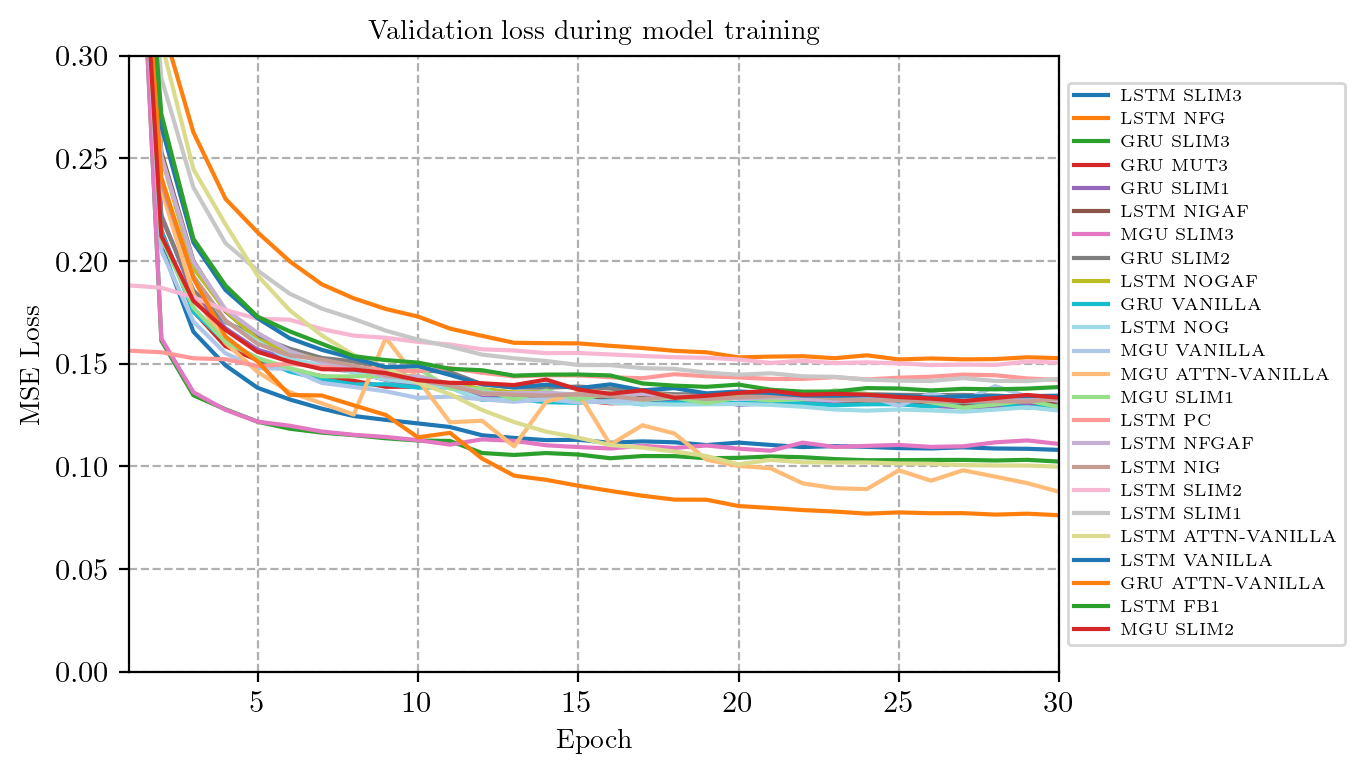

In [47]:
cmap = plt.get_cmap('tab20')
colors = [cmap(i) for i in range(0,21,2)] + \
         [cmap(i+1) for i in range(0,21,2)]

# Get images folder and filepath
imagesfolder = os.path.join(utils.cwd, 'images')
filepath = os.path.join(imagesfolder,'training_validation_loss.pdf')

# Iterate over all elements in the folder
fig, ax = plt.subplots(figsize=(6,4))

# Iterate over all trained network
for i, (network_name, data) in enumerate(data_plot.items()):

    data = pd.Series(data['validation_loss'], data['epochs'])
            
    ax.plot(data.drop_duplicates(keep='first'), 
            label = network_name.replace('_',' ').upper(), 
            color = colors[i%20])

ax.set_title('Validation loss during model training', fontsize=10)
ax.set_xlabel('Epoch', fontsize=10)
ax.set_ylabel('MSE Loss', fontsize=10)
ax.set_ylim(0,0.3)
ax.set_xlim(1, 30)
ax.legend(fontsize=6, loc='center left', bbox_to_anchor=(1, 0.5))
ax.grid(True, linestyle='--')
fig.savefig(filepath, bbox_inches='tight')

### 3.2.- Training one of the networks

#### 3.2.1 - Model instanciation

In [ ]:
# Set the network to train.
network_name = 'lstm_fb1'



# Get model's filename where the parameters are saved.
filename = f'cef_{network_name}_' + \
        f'hs{df_networks.loc[network_name]["hidden_size"]}_' + \
        f'nl{df_networks.loc[network_name]["num_layers"]}_parameters.pt'

# Get filepath for the model and print it        
filepath = os.path.join(utils.cwd, 'models', filename)

if not os.path.exists(filepath):
    print(f'Model parameters not available in {filepath}')
else:
    print(f'Model parameters loaded from: {filename}')

# Get the network object
network = nws.networks[network_name]

# Initialize model.
model = xnn.ConjunctionEventForecaster(network = network, 
                                        features = nn_features)
    

#### 3.2.2.- Training the model

In [21]:
# Train the model
model.learn(events_train_and_val, epochs = 10, lr = 1e-5, batch_size = 15, 
            device = 'cpu', event_samples_for_stats = 2000,
            filepath = filepath, epoch_step_checkpoint = 5)

Number of learnable parameters of the model: 922,144

Model parameters loaded from /Users/jjrr/Documents/SCA-Project/scalib/models/cef_lstm_fb1_hs263_nl2_parameters.pt
 - Total epochs       = 20
 - Total iterations   = 2080
 - Validation loss    = 1.3985e-01
 - Last learning rate = 1.0000e-04




TRAINING FORECASTING MODEL:
| Progress                     |    Time     | Iters/sec | Comments
| 100% |██████████| (1040/1040)| 00h:15m:26s |   1.12    | E(10/10) B(104/104) | Loss > T(1.1982e-01) V(1.3868e-01)

Saving model parameters ... Done.


In [18]:
# Print the last validation losses to see if model has improved over the last
# iterations.
print('\nLast 5 validation losses:')
display(pd.Series(model._learn_results['validation_loss'],
                  model._learn_results['epoch'])
                  .drop_duplicates(keep='first')
                  .sort_index(ascending=False).head(5))


Last 5 validation losses:


10    0.150580
9     0.151800
8     0.153662
7     0.159790
6     0.165809
dtype: float64

#### 3.2.3.- Using the model to forecast Conjunction Events

In [ ]:
# Take a single event from test dataset and remove the last CDM.
event_idx = 2
event = events_test[event_idx]
event_beginning = event[0:len(event)-1]

# Print information about the event to forecast.
print(f'Forecasting next CDM from previous {len(event)} CDM(s)...')

# Predict the evolution of the conjunction event until TCA or the number of CDMs
# is max_length.
event_evolution = model.predict_event(event = event_beginning, 
                                      num_samples = 10, 
                                      max_length = 14)

# List of features to predict.
features = ['RELATIVE_SPEED', 'MISS_DISTANCE', 'OBJECT1_CT_T']

# Plot prediction in red
axs = event_evolution.plot_features(features = features, return_axs = True, 
                                    linewidth = 0.1, color = 'red', alpha=0.33, 
                                    label = 'Prediction')
#and the ground truth value in blue:
event.plot_features(features=features, axs=axs, label='Actual', legend = True)

## Comparing models performance

In [48]:
reload(xnn)
# Get directory where the model parameters are saved.
folderpath = os.path.join(utils.cwd, 'models')

# Define batch_size for test
test_batch_size = 10

# Initialiaze dictionary to store the list
data_test = {}

# Initialize progress bar.
pb_networks = utils.ProgressBar(iterations=range(len(nws.networks)),
                                title='TESTING NETWORKS PERFORMANCE:')
# Iterate over all available networks
for n, (network_name, network) in enumerate(nws.networks.items()):
    
    filepath = ''
    for filename in os.listdir(folderpath):
        if '_' + network_name + '_' in filename: 
            filepath = os.path.join(folderpath, filename)
            break

    if filepath=='': continue

    # Initialize model.
    model = xnn.ConjunctionEventForecaster(network = network, 
                                           features = nn_features)
    
    # Load parameters into the model
    model.load(filepath = filepath)

    # Test model usinf the events_test dataset.
    test_results = model.test(events_test, test_batch_size = test_batch_size)

    # Add data to the dictionary.
    data_test[network_name] = test_results

    # Update progress bar
    description = f'Network: {network_name:12} ' + \
                  f'MSE -> Mean = {np.mean(test_results["mse"]):6.4e}' + \
                  f'Std. Dev = {np.std(test_results["mse"]):6.4e}'
    pb_networks.refresh(i=n+1, description=f'Network: {network_name}')



TESTING NETWORKS PERFORMANCE:
| Progress                 |    Time     | Iters/sec | Comments
| 100% |██████████| (24/24)| 00h:10m:18s |   0.04    | Network: mgu_attn-vanilla 


In [49]:
# Model evaluation metrics:
# - SSE (Sum of Squared Errors)
# - MSE (Mean Squared Errors)
# - MAE (Mean Absolute Errors)
# - AIC (Akaike Information Criterion)
# - BIC (Bayesian Information Criterion): When fitting models, it is possible to 
#   increase the likelihood by adding parameters, but doing so may result in 
#   overfitting. BIC introduces a penalty term for the number of parameters in 
#   the model. The penalty term is larger in BIC than in AIC.

# Initialize dictionary to store the results from the different regression 
# evaluation metrics
data_stats = {}

df_stats = pd.DataFrame(index = list(data_test.keys()))
for metric in ['mse', 'mae', 'sse', 'aic', 'bic']:

    # Get metric results from all networks evaluated
    for network_name, network_data in data_test.items():
        data_stats[network_name] = network_data[metric]

    # Convert dictionary to Pandas DataFrame.
    df_metric = pd.DataFrame.from_dict(data=data_stats, orient='columns')
    
    # Transpose DataFrame and rename columns
    df_metric = df_metric.describe().transpose()
    df_metric = df_metric[['mean', 'std','50%']] \
                    .rename(columns={'mean':f'{metric}_mean', 
                                     'std':f'{metric}_std',
                                     '50%':f'{metric}_median'})
    
    # Append metric DataFrame to final dataframe
    df_stats = pd.concat([df_stats, df_metric], axis=1)

df_stats.sort_values(by='mse_mean', ascending=True, inplace=True)

# Compute deltas vs min values for AIC and BIC scores
df_stats['aic_delta'] = df_stats['aic_mean']-df_stats['aic_mean'].min()
df_stats['bic_delta'] = df_stats['bic_std']-df_stats['bic_std'].min()

# Save to CSV regression scores.
df_stats.to_csv('networks_test_regression_scores.csv')

# Show DataFrame
display(df_stats)

,mse_mean,mse_std,mse_median,mae_mean,mae_std,mae_median,sse_mean,sse_std,sse_median,aic_mean,aic_std,aic_median,bic_mean,bic_std,bic_median,aic_delta,bic_delta
gru_attn-vanilla,0.098141,0.053184,0.080902,0.129216,0.024642,0.126885,1360.228247,737.132211,1121.297424,1.844404e+06,5.253396,1.844403e+06,2.123441e+06,5.253396,2.123440e+06,63.307525,2.450991
mgu_attn-vanilla,0.114554,0.063905,0.104563,0.150712,0.035859,0.155373,1587.718896,885.721254,1449.247009,1.850029e+06,5.663265,1.850030e+06,2.129917e+06,5.663265,2.129918e+06,5688.678913,2.860860
gru_slim3,0.125288,0.069175,0.117099,0.127752,0.028263,0.129521,1736.498474,958.771687,1622.996399,1.851590e+06,5.685053,1.851591e+06,2.131714e+06,5.685053,2.131715e+06,7249.582058,2.882648
lstm_attn-vanilla,0.127067,0.066805,0.113810,0.139770,0.024807,0.138516,1761.142383,925.917400,1577.401917,1.853983e+06,4.740226,1.853983e+06,2.134469e+06,4.740226,2.134469e+06,9642.079534,1.937821
lstm_slim3,0.131916,0.053830,0.137494,0.132222,0.025012,0.137914,1828.349658,746.087668,1905.660767,1.853385e+06,4.466161,1.853386e+06,2.133781e+06,4.466161,2.133782e+06,9044.681862,1.663756
mgu_slim3,0.135830,0.065455,0.122035,0.141371,0.020828,0.139993,1882.607422,907.202056,1691.400757,1.849797e+06,4.354313,1.849797e+06,2.129650e+06,4.354313,2.129650e+06,5456.915726,1.551908
gru_vanilla,0.154383,0.049367,0.147548,0.156522,0.029203,0.157702,2139.750171,684.225827,2045.015808,1.850873e+06,3.248750,1.850873e+06,2.130888e+06,3.248750,2.130888e+06,6532.622080,0.446345
lstm_nigaf,0.154417,0.061375,0.161203,0.159608,0.034366,0.171255,2140.213403,850.661327,2234.272827,1.855577e+06,4.610582,1.855578e+06,2.136304e+06,4.610582,2.136305e+06,11236.234181,1.808177
lstm_nig,0.157539,0.061336,0.145366,0.156561,0.028643,0.151073,2183.493237,850.117491,2014.768799,1.854545e+06,4.144372,1.854545e+06,2.135116e+06,4.144372,2.135116e+06,10204.564842,1.341967
lstm_nogaf,0.158083,0.045680,0.148864,0.161491,0.018817,0.156870,2191.024414,633.121664,2063.252441,1.855578e+06,2.802405,1.855577e+06,2.136304e+06,2.802405,2.136304e+06,11236.968988,0.000000


In [50]:
# Initialize dictionary to store the MSE loss per model and batch.
data_mse = {}
for network_name, network_data in data_test.items():
    data_mse[network_name] = network_data['mse']

# Convert dictionary to Pandas DataFrame (rows = batch, columns = networks).
df_test_mse = pd.DataFrame.from_dict(data = data_mse, orient='columns')

# Reorder the columns in the original dataset to be ordered by the loss mean
df_test_mse = df_test_mse[df_stats.index]

# Save results in a CSV file.
df_test_mse.to_csv(f'networks_test_mse_bs{test_batch_size}.csv')

display(df_test_mse)

,gru_attn-vanilla,mgu_attn-vanilla,gru_slim3,lstm_attn-vanilla,lstm_slim3,mgu_slim3,gru_vanilla,lstm_nigaf,lstm_nig,lstm_nogaf,...,gru_slim1,mgu_slim1,lstm_vanilla,gru_slim2,lstm_fb1,mgu_slim2,lstm_pc,lstm_slim1,lstm_nfg,lstm_slim2
0,0.060732,0.229537,0.183516,0.106650,0.061228,0.153264,0.209319,0.148896,0.094241,0.190042,...,0.156661,0.286568,0.194253,0.056911,0.034779,0.280507,0.199884,0.131507,0.145547,0.108194
1,0.037483,0.054052,0.136712,0.202383,0.071892,0.069762,0.227133,0.064202,0.206122,0.143483,...,0.170016,0.131180,0.085500,0.111422,0.285490,0.131151,0.107130,0.056481,0.241535,0.089573
2,0.102421,0.053092,0.122400,0.098629,0.161775,0.104358,0.102387,0.071450,0.141332,0.117811,...,0.083798,0.258786,0.294019,0.084638,0.178248,0.141847,0.238336,0.287299,0.200220,0.316714
3,0.064079,0.125286,0.051074,0.278935,0.168948,0.139569,0.110987,0.253427,0.278178,0.214450,...,0.114868,0.119301,0.204815,0.121238,0.115144,0.217548,0.198464,0.140210,0.251223,0.146919
4,0.202503,0.162033,0.249207,0.129996,0.067773,0.069820,0.132605,0.204167,0.116047,0.126160,...,0.174126,0.128794,0.116171,0.180183,0.191057,0.171913,0.226144,0.174755,0.112213,0.153932
5,0.093346,0.083840,0.111798,0.083504,0.144045,0.154148,0.162491,0.173510,0.198034,0.243851,...,0.155745,0.157556,0.161235,0.200473,0.385082,0.146136,0.194321,0.153743,0.098382,0.155387
6,0.168400,0.057276,0.065295,0.071772,0.130943,0.100741,0.213600,0.205474,0.066520,0.126961,...,0.092191,0.134100,0.126845,0.191471,0.147326,0.083529,0.086134,0.105956,0.205238,0.394296
7,0.057407,0.129758,0.062440,0.055063,0.125758,0.104500,0.092134,0.102374,0.148768,0.163674,...,0.138848,0.205905,0.226248,0.249188,0.091364,0.252930,0.120039,0.280041,0.100609,0.148413
8,0.126576,0.058109,0.061922,0.122765,0.234364,0.168466,0.168874,0.180602,0.184187,0.100148,...,0.268697,0.099700,0.086660,0.287761,0.086214,0.138671,0.192909,0.301183,0.220700,0.207322
9,0.068458,0.192557,0.208521,0.120969,0.152430,0.293674,0.124302,0.140063,0.141964,0.154245,...,0.261845,0.103594,0.154579,0.173156,0.148374,0.123018,0.169332,0.160638,0.254295,0.142907


In [51]:
# Display test loss dataframe and statistics
#df_test_mse = pd.read_csv('networks_test_mse_bs10.csv',index_col=0)

# Get mean, standard deviation, and median 
df_test_mse_stats = df_stats[[c for c in df_stats.columns if c[:3]=='mse']]

# Get MSE results from LSTM network with Vanilla cell architecture (Kessler)
mse_vanilla = df_stats.loc['lstm_vanilla']['mse_mean']

df_test_mse_stats['delta'] = 1 - df_test_mse_stats['mse_mean']/mse_vanilla

display(df_test_mse_stats)

/var/folders/m2/1phpry2j5w739bgs4cqbg0pw0000gn/T/ipykernel_11435/4210431033.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_mse_stats['delta'] = 1 - df_test_mse_stats['mse_mean']/mse_vanilla


,mse_mean,mse_std,mse_median,delta
gru_attn-vanilla,0.098141,0.053184,0.080902,0.405326
mgu_attn-vanilla,0.114554,0.063905,0.104563,0.305870
gru_slim3,0.125288,0.069175,0.117099,0.240825
lstm_attn-vanilla,0.127067,0.066805,0.113810,0.230051
lstm_slim3,0.131916,0.053830,0.137494,0.200669
mgu_slim3,0.135830,0.065455,0.122035,0.176948
gru_vanilla,0.154383,0.049367,0.147548,0.064528
lstm_nigaf,0.154417,0.061375,0.161203,0.064326
lstm_nig,0.157539,0.061336,0.145366,0.045405
lstm_nogaf,0.158083,0.045680,0.148864,0.042112


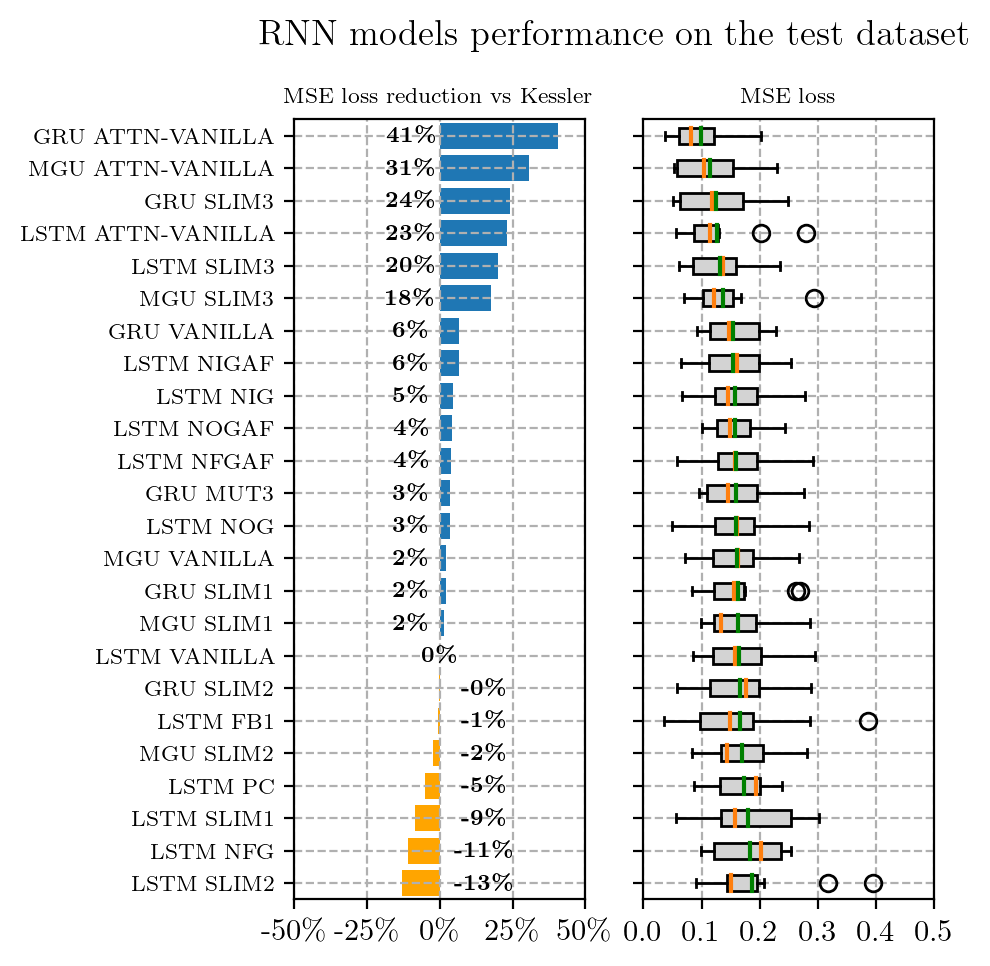

In [66]:
import matplotlib.ticker as mtick

# function to add value labels
def addlabels(ax, x,y):
    for i in range(len(x)):
        offset = 0
        if y[i]>0:
            offset = -0.1
        elif  y[i]<0:
            offset = 0.15
        ax.text(offset, i, r'\textbf{' + f'{y[i]*100:3.0f}\%' + '}', 
                ha = 'center', va = 'center', fontdict=dict(fontsize=8))


fig, (ax_hb, ax_bp) = plt.subplots(nrows=1, ncols=2, figsize=(4,5), sharey=True)

fig.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    wspace=0.2,
                    hspace=0.4)

# Set the figure title
fig.suptitle('RNN models performance on the test dataset') 

# Get the labels for the Y-axis
labels = [l.replace('_',' ').upper() for l in df_test_mse.columns]

# Plot the boxplot

ax_bp.boxplot(df_test_mse, positions = np.arange(len(labels)), 
              vert = False, showmeans = True, meanline = True, 
              meanprops = dict(linestyle='-', linewidth=1.5, color='green'), 
              medianprops = dict(linewidth=1.5), 
              boxprops = dict(facecolor = "lightgrey"), 
              showfliers = True, patch_artist=True)

# Set the Y-axis labels to the right position for the boxplot.
#ax_bp.yaxis.set_ticks_position('right')

# Set the X-axis label and ticks for the boxplot
ax_bp.set_title('MSE loss', fontsize=8)
ax_bp.set_xticks(np.linspace(0,0.5,6))

# Plot horizontalm bars with the delta.
colors = ['tab:blue']*sum(df_test_mse_stats['delta']>0) + \
    ['orange']*sum(df_test_mse_stats['delta']<=0)

ax_hb.barh(labels, df_test_mse_stats['delta'], color = colors, align='center')
addlabels(ax_hb, labels,df_test_mse_stats['delta'])

# Set the X-axis label and format for the ticks
ax_hb.set_title('MSE loss reduction vs Kessler', fontsize=8)
ax_hb.xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))

# Set the limits and ticks for the horizontal bar plot
ax_hb.set_xlim(-0.5,0.5)
ax_hb.set_xticks(np.linspace(-0.5,0.5,5))


# Set general format for both plots 
for ax in [ax_bp, ax_hb]: ax.grid(True, linestyle='--')
ax_hb.set_yticklabels(labels, fontsize=8)
       
ax_hb.invert_yaxis()

figpath = os.path.join(utils.cwd,'notebooks','images','rnn_models_performance')
fig.savefig(figpath + '.pdf', bbox_inches = "tight")
